In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from joblib import dump, load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_csv('C:/Users/Tad/Documents/faceoffs/dataset_300k_rel_cols_no_na_processed_subset.csv')
print("data read")

data read


In [3]:
# Principal Component Analysis
data_all = data.dropna()
#data_all = data_all[data_all['event_zone'] == 'Off']
data = data_all.select_dtypes(['number'])
x = data.loc[:, data.columns != 'net_xg']
x = x.loc[:, x.columns != 'net_xg']
y = data['net_xg']
#pca = PCA(n_components = 100)
#print("pca fitting")
#principal_components = pca.fit_transform(x)
#print(principal_components)
#principal_components_df = pd.DataFrame(principal_components)
#principal_components_df.to_csv("principal_components_newest.csv")

In [4]:
# Prep Train and Test Data
objectives = data['net_xg']
#principal_components_df['net_xg'] = objectives
#data_no_na = principal_components_df.dropna() # FLAG
#data_no_na = data.dropna()
#X = data_no_na.loc[:, data_no_na.columns != 'net_xg']
#X = X.loc[:, X.columns != 'net_xg']
#X = OneHotEncoder(categories = 'auto').fit_transform(X)
#y = data_no_na['net_xg']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42) # X became x
print("completed train-test split")

completed train-test split


In [5]:
# Build initial, untuned random forest model
print(datetime.now())
# rf_initial = RandomForestRegressor().fit(x_train, y_train)
# print("completed RandomForestRegressor initial fitting")
# prediction_initial = rf_initial.predict(x_test)
# mse_initial = mean_squared_error(y_test, prediction_initial)
# rmse_initial = mse_initial ** .5
# print(mse_initial)
# print(rmse_initial)
# print(datetime.now())

2023-04-13 14:29:37.108389


In [6]:
# Initial Big Picture Tuning using RandomizedSearchCV
print(datetime.now())

# random_grid = { # FLAG
#     'bootstrap': [True],
#     'max_depth': [10, 25, 50, 100, 500, 1000],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_leaf': [5, 10],
#     'min_samples_split': [5, 10, 25, 50],
#     'n_estimators': [100, 250, 500, 1000],
# }
random_grid = { # FLAG
    'bootstrap': [True, False],
    'max_depth': [10, 25, 50, 100, 500, 1000],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [5, 10, 25, 50],
    'min_samples_split': [5, 10, 25, 50, 100],
    'n_estimators': [100, 200, 400, 600, 800, 1000, 2000, 5000],
}

# SOLELY FOR TESTING WHETHER CODE COMPILES (FLAG)
# random_grid = {
#     'bootstrap': [True],
#     'max_depth': [5],
#     'max_features': ['auto'],
#     'min_samples_leaf': [2],
#     'min_samples_split': [2],
#     'n_estimators': [15],
# }

rf_tuning = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_tuning, param_distributions = random_grid, n_iter = 100, cv = 5, verbose = 2, random_state = 42, n_jobs = -1) # FLAG (n_iter)
rf_fit_output = rf_random.fit(x_train, y_train)
print("writing joblib")
dump(rf_fit_output, 'rf_updated_new2.joblib') #FLAG... change suffix
print(datetime.now())

2023-04-13 14:29:38.392406
Fitting 5 folds for each of 100 candidates, totalling 500 fits
writing joblib
2023-04-13 14:43:36.824373


In [7]:
# def evaluate(model, test_features, test_labels):
#     predictions = model.predict(test_features)
#     errors = abs(predictions - test_labels)
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
#     print('Model Performance')
#     print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
#
#     return accuracy

In [8]:
best_random = rf_random.best_estimator_
# random_accuracy = evaluate(best_random, x_test, y_test)

predictions = rf_fit_output.predict(x_test)
errors = abs(predictions - y_test)
# from sklearn.metrics import r2_score
# r_sq = r2_score(y_test, predictions)
# mse_grid = mean_squared_error(y_test, predictions)
# print(mse_grid)
# rmse_grid = mse_grid ** .5
# print(rmse_grid)
#
# # Display the performance metrics
# print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# mape = np.mean(100 * (errors / y_test))
# accuracy = 100 - np.mean(mape[np.isfinite(mape)])
# print('Accuracy:', round(accuracy, 2), '%.')
# See https://stackoverflow.com/questions/58067438/mape-mean-absolute-percentage-error-measurement-in-python-result-in-error#:~:text=mape%20%3D%20100%20*%20(errors%20%2F,')

best_bootstrap = best_random.bootstrap
best_max_depth = best_random.max_depth
best_max_features = best_random.max_features
best_min_samples_leaf = best_random.min_samples_leaf
best_min_samples_split = best_random.min_samples_split
best_n_estimators = best_random.n_estimators

best_parameters = rf_fit_output.best_params_


In [9]:
rf_best_param = RandomForestRegressor(bootstrap = best_bootstrap,
                                      max_depth = best_max_depth,
                                      max_features = best_max_features,
                                      min_samples_leaf = best_min_samples_leaf,
                                      min_samples_split = best_min_samples_split,
                                      n_estimators = best_n_estimators)
rf_best_param_fit = rf_best_param.fit(x_train, y_train)
dump(rf_best_param_fit, 'rf_updated_new_best2.joblib') # FLAG... change suffix

['rf_updated_new_best2.joblib']

In [17]:
prediction = rf_best_param_fit.predict(x_test)
mse = mean_squared_error(y_test, prediction)
rmse = mse**.5
print(mse)
print(rmse)
print(pd.Series(prediction).corr(y_test, method = 'pearson'))

0.0031043726043757506
0.055716896937784956
0.04011469677896279


<Axes: title={'center': 'RANDOM FOREST FEATURE IMPORTANCE'}, ylabel='FEATURE NAMES'>

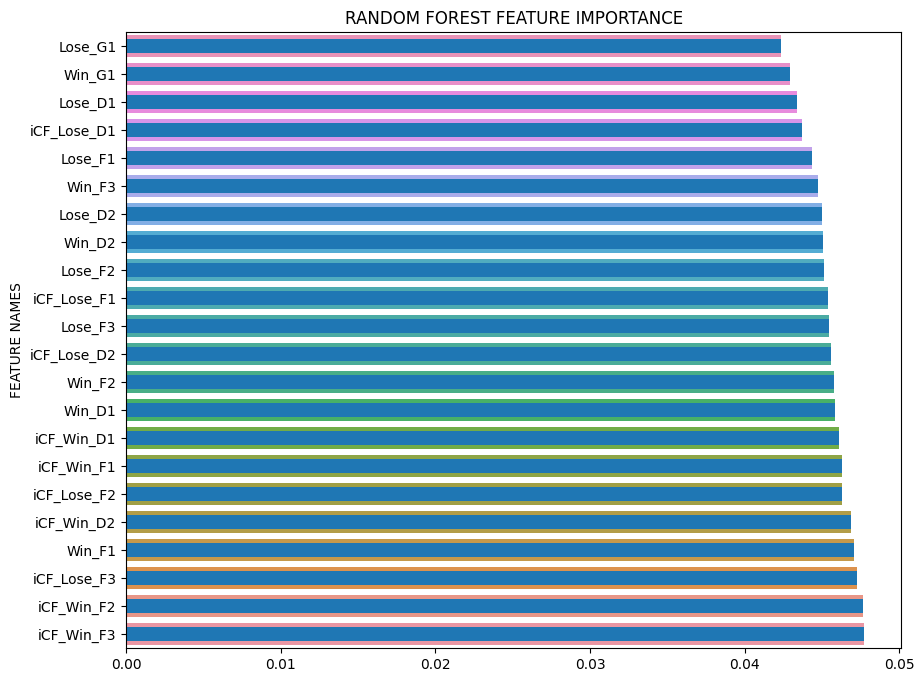

In [10]:
var_imps = rf_best_param_fit.feature_importances_

def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    df ={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(df)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(rf_best_param_fit.feature_importances_, x_train.columns,'RANDOM FOREST ')

feat_importances_series = pd.Series(var_imps, index=x_train.columns)
feat_importances_series.nlargest(50).plot(kind='barh')